# Аналитика в Яндекс.Афише

## Описание данных
Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## Задачи исследования

Помочь маркетологам оптимизировать маркетинговые затраты.
1. Изучить Продукт
    - Сколько людей пользуются в день, неделю, месяц?
    - Сколько сессий в день?
    - Сколько длится одна сессия?
    - Как часто люди возвращаются?
2. Изучить Продажи
    - Когда люди начинают покупать?
    - Сколько раз покупают за период?
    - Какой средний чек?
    - Сколько денег приносят? (LTV)
3. Изучить Маркетинг
    - Сколько денег потратили? Всего / на каждый источник / по времени
    - Сколько стоило привлечение одного покупателя из каждого источника?
    - На сколько окупились расходы? (ROI)

### 1. Подготовка данных

In [1]:
# настраиваем окружение
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from math import ceil
import seaborn as sns
import numpy as np
from scipy import stats as st
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

In [2]:
#visits_log = pd.read_csv('C:\\Y.Practikum\\project_6\\dataset\\visits_log.csv', sep=',')
visits_log = pd.read_csv('/datasets/visits_log.csv', sep=',')

visits_log.info()
visits_log.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
#orders_log = pd.read_csv('C:\\Y.Practikum\\project_6\\dataset\\orders_log.csv', sep=',')
orders_log = pd.read_csv('/datasets/orders_log.csv', sep=',')

orders_log.info()
orders_log.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [4]:
#costs = pd.read_csv('C:\\Y.Practikum\\project_6\\dataset\\costs.csv', sep=',')
costs = pd.read_csv('/datasets/costs.csv', sep=',')

costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [5]:
# переименуем столбцы, поменяем тип полей для столбцов с датами
visits_log.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'], format='%Y-%m-%d %H:%M:%S')

# выделим неделю и месяц заказа
visits_log['session_day'] = visits_log['start_ts'].dt.date
visits_log['session_week'] = visits_log['start_ts'].astype('datetime64[W]')
visits_log['session_month'] = visits_log['start_ts'].astype('datetime64[M]')

visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 8 columns):
device           359400 non-null object
end_ts           359400 non-null datetime64[ns]
source_id        359400 non-null int64
start_ts         359400 non-null datetime64[ns]
uid              359400 non-null uint64
session_day      359400 non-null object
session_week     359400 non-null datetime64[ns]
session_month    359400 non-null datetime64[ns]
dtypes: datetime64[ns](4), int64(1), object(2), uint64(1)
memory usage: 21.9+ MB


In [6]:
orders_log.columns = ['buy_ts', 'revenue', 'uid']

orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'], format='%Y-%m-%d %H:%M:%S')

# удалим заказы с нулевым revenue
orders_log = orders_log.query('revenue > 0')

orders_log['order_day'] = orders_log['buy_ts'].dt.date
orders_log['order_week'] = orders_log['buy_ts'].astype('datetime64[W]')
orders_log['order_month'] = orders_log['buy_ts'].astype('datetime64[M]')

orders_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50364 entries, 0 to 50414
Data columns (total 6 columns):
buy_ts         50364 non-null datetime64[ns]
revenue        50364 non-null float64
uid            50364 non-null uint64
order_day      50364 non-null object
order_week     50364 non-null datetime64[ns]
order_month    50364 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(1), uint64(1)
memory usage: 2.7+ MB


In [7]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

costs['cost_month'] = costs['dt'].astype('datetime64[M]')

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
source_id     2542 non-null int64
dt            2542 non-null datetime64[ns]
costs         2542 non-null float64
cost_month    2542 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 79.6 KB


In [8]:
# выделим даты первого события в датасетах
# первая сессия пользователя
first_session_time = visits_log.groupby('uid')['start_ts'].min()
first_session_time.name = 'first_session_time'

visits_log = pd.merge(visits_log, first_session_time, on='uid')
visits_log['first_session_day'] = visits_log['first_session_time'].dt.date
visits_log['first_session_month'] = visits_log['first_session_day'].astype('datetime64[M]')

In [9]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359400 entries, 0 to 359399
Data columns (total 11 columns):
device                 359400 non-null object
end_ts                 359400 non-null datetime64[ns]
source_id              359400 non-null int64
start_ts               359400 non-null datetime64[ns]
uid                    359400 non-null uint64
session_day            359400 non-null object
session_week           359400 non-null datetime64[ns]
session_month          359400 non-null datetime64[ns]
first_session_time     359400 non-null datetime64[ns]
first_session_day      359400 non-null object
first_session_month    359400 non-null datetime64[ns]
dtypes: datetime64[ns](6), int64(1), object(3), uint64(1)
memory usage: 32.9+ MB


In [10]:
# платформа и источник для первой сессии пользователя
first_session_attr = visits_log[['uid', 'start_ts', 'device', 'source_id']]
first_session_attr.columns = ['uid', 'first_session_time', 'first_session_device', 'first_session_source']

# first_session_time - дата и время начала первой сессии.
# добавим в датасет данные из первой сессии пользователя
visits_log = pd.merge(visits_log, first_session_attr, on=['uid', 'first_session_time'])

In [11]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359402 entries, 0 to 359401
Data columns (total 13 columns):
device                  359402 non-null object
end_ts                  359402 non-null datetime64[ns]
source_id               359402 non-null int64
start_ts                359402 non-null datetime64[ns]
uid                     359402 non-null uint64
session_day             359402 non-null object
session_week            359402 non-null datetime64[ns]
session_month           359402 non-null datetime64[ns]
first_session_time      359402 non-null datetime64[ns]
first_session_day       359402 non-null object
first_session_month     359402 non-null datetime64[ns]
first_session_device    359402 non-null object
first_session_source    359402 non-null int64
dtypes: datetime64[ns](6), int64(2), object(4), uint64(1)
memory usage: 38.4+ MB


In [12]:
# месяц первого заказа
first_order_month = orders_log.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_order_month.columns = ['uid', 'first_order_month']

orders_log = pd.merge(orders_log, first_order_month, on='uid')

In [13]:
# платформа пользователя (первой сессии)
buyers = orders_log['uid'].unique()

first_session_device = visits_log.query('uid in @buyers')[['uid', 'first_session_device']]
first_session_device.drop_duplicates(inplace=True)

orders_log = pd.merge(orders_log, first_session_device, on='uid')

In [14]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50364 entries, 0 to 50363
Data columns (total 8 columns):
buy_ts                  50364 non-null datetime64[ns]
revenue                 50364 non-null float64
uid                     50364 non-null uint64
order_day               50364 non-null object
order_week              50364 non-null datetime64[ns]
order_month             50364 non-null datetime64[ns]
first_order_month       50364 non-null datetime64[ns]
first_session_device    50364 non-null object
dtypes: datetime64[ns](4), float64(1), object(2), uint64(1)
memory usage: 3.5+ MB


__Данные подготовлены к анализу__, пропусков в данных нет.
Названия столбцов приведены к единому виду, заменен тип данных для столбцов с датами.

### 2. Изучение Продукта
Задачи:
- Сколько людей пользуются в день, неделю, месяц? Расчитаем показатели DAU, WAU, MAU.
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются? Расчитаем Retention rate

#### 2.1 Анализ аудитории сервиса - Сколько людей пользуются в день, неделю, месяц?

Посчитаем DAU, WAU, MAU общие значения, а также в разрезе устройств и рекламных каналов. Посмотрим, где больше аудитория.

In [15]:
# расчет DAU, WAU, MAU
dau_total = int(visits_log.groupby('session_day').agg({'uid': 'nunique'}).mean())
wau_total = int(visits_log.groupby('session_week').agg({'uid': 'nunique'}).mean())
mau_total = int(visits_log.groupby('session_month').agg({'uid': 'nunique'}).mean())

print('Total значения:')
print('DAU: {}'.format(dau_total))
print('WAU: {}'.format(wau_total))
print('MAU: {}'.format(mau_total))

Total значения:
DAU: 907
WAU: 5724
MAU: 23228


In [16]:
# пересчитаем показатели в разрезе устройств
dau_by_device = (visits_log.groupby(['device', 'session_day'])
                 .agg({'uid': 'nunique'})
                ).groupby('device').agg({'uid': 'mean'}).reset_index()

wau_by_device = (visits_log.groupby(['device', 'session_week'])
                 .agg({'uid': 'nunique'})
                ).groupby('device').agg({'uid': 'mean'}).reset_index()

mau_by_device = (visits_log.groupby(['device', 'session_month'])
                 .agg({'uid': 'nunique'})
                ).groupby('device').agg({'uid': 'mean'}).reset_index()

dau_by_device.columns = ['device', 'dau']
wau_by_device.columns = ['device', 'wau']
mau_by_device.columns = ['device', 'mau']

dwm_by_device = dau_by_device.merge(wau_by_device)
dwm_by_device = dwm_by_device.merge(mau_by_device)

dwm_by_device['dau'] = round(dwm_by_device['dau']).astype('int64')
dwm_by_device['wau'] = round(dwm_by_device['wau']).astype('int64')
dwm_by_device['mau'] = round(dwm_by_device['mau']).astype('int64')

print('Аудитория сервиса в разрезе типов платформ:\n', dwm_by_device)

Аудитория сервиса в разрезе типов платформ:
     device  dau   wau    mau
0  desktop  659  4136  16725
1    touch  253  1637   6826


Аудитория сервиса в разрезе типов платформ:


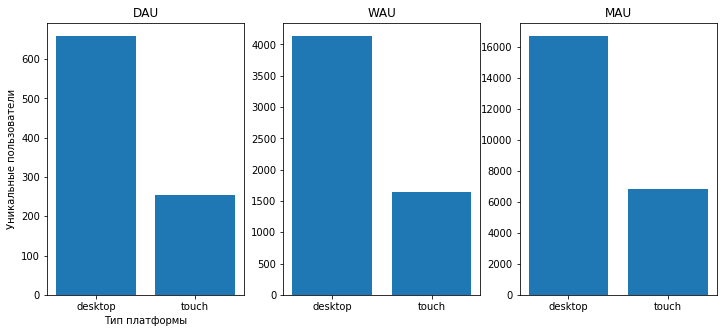

In [17]:
# графики параметров для устройств
fig = plt.figure(figsize=(12,5))

ax_1 = fig.add_subplot(1, 3, 1)
ax_2 = fig.add_subplot(1, 3, 2)
ax_3 = fig.add_subplot(1, 3, 3)

ax_1.set(title='DAU')
ax_2.set(title='WAU')
ax_3.set(title='MAU')

ax_1.set_ylabel('Уникальные пользователи')
ax_1.set_xlabel('Тип платформы')

ax_1.bar(dwm_by_device['device'], dwm_by_device['dau'])
ax_2.bar(dwm_by_device['device'], dwm_by_device['wau'])
ax_3.bar(dwm_by_device['device'], dwm_by_device['mau'])

print('Аудитория сервиса в разрезе типов платформ:')
plt.show()

In [18]:
# пересчитаем показатели в разрезе рекламных каналов
dau_by_source = (visits_log.groupby(['source_id', 'session_day'])
                 .agg({'uid': 'nunique'})
                ).groupby('source_id').agg({'uid': 'mean'}).reset_index()

wau_by_source = (visits_log.groupby(['source_id', 'session_week'])
                 .agg({'uid': 'nunique'})
                ).groupby('source_id').agg({'uid': 'mean'}).reset_index()

mau_by_source = (visits_log.groupby(['source_id', 'session_month'])
                 .agg({'uid': 'nunique'})
                ).groupby('source_id').agg({'uid': 'mean'}).reset_index()

dau_by_source.columns = ['source_id', 'dau']
wau_by_source.columns = ['source_id', 'wau']
mau_by_source.columns = ['source_id', 'mau']

dwm_by_source = dau_by_source.merge(wau_by_source)
dwm_by_source = dwm_by_source.merge(mau_by_source)

dwm_by_source['dau'] = round(dwm_by_source['dau']).astype('int64')
dwm_by_source['wau'] = round(dwm_by_source['wau']).astype('int64')
dwm_by_source['mau'] = round(dwm_by_source['mau']).astype('int64')

print('Аудитория сервиса в разрезе каналов привлечения:\n', dwm_by_source)

Аудитория сервиса в разрезе каналов привлечения:
    source_id  dau   wau   mau
0          1   81   465  1819
1          2  121   716  2752
2          3  233  1566  6759
3          4  275  1831  7766
4          5  176  1168  5018
5          6    1     1     1
6          7    1     1     3
7          9   36   238   987
8         10   26   167   707


Аудитория сервиса в разрезе каналов привлечения:


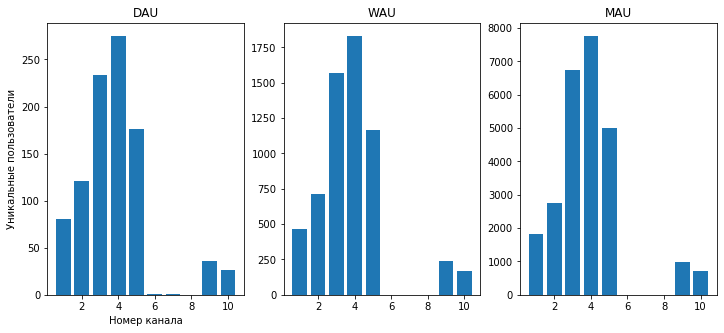

In [19]:
# графики параметров для рекламных каналов
fig = plt.figure(figsize=(12,5))

ax_1 = fig.add_subplot(1, 3, 1)
ax_2 = fig.add_subplot(1, 3, 2)
ax_3 = fig.add_subplot(1, 3, 3)

ax_1.set(title='DAU')
ax_2.set(title='WAU')
ax_3.set(title='MAU')

ax_1.set_ylabel('Уникальные пользователи')
ax_1.set_xlabel('Номер канала')

ax_1.bar(dwm_by_source['source_id'], dwm_by_source['dau'])
ax_2.bar(dwm_by_source['source_id'], dwm_by_source['wau'])
ax_3.bar(dwm_by_source['source_id'], dwm_by_source['mau'])

print('Аудитория сервиса в разрезе каналов привлечения:')
plt.show()

- Расчитаны показатели аудитории сервиса:  
    DAU: 907  
    WAU: 5716  
    MAU: 23228  
- С desktop устройств пользователей приходит в 2 раза больше чем с других устройств
- Рекламные кампании с source_id - 4, 3, 5 приводят наибольшее кол-во пользователей
- Рекламные каналы 6, 7, 8 приводят минимальное кол-во пользователей.

#### 2.2 Анализ пользовательских сессий
Сколько сессий в день?  
Сколько длится одна сессия?

Посчитаем среднее кол-во сессий в день и месяц, кол-во сессий в разрезе устройств, среднюю длительность сессий в день (ASL)

In [20]:
# добавим в датасет длительность сессий
visits_log['duration'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds

# исключим сессии с нулевой длительностью
sessions = visits_log.query('duration > 0')

In [21]:
sessions_by_day = sessions.groupby('session_day').agg({'uid': 'count'})

sessions_by_day.describe()

,uid
count,364.000000
mean,889.030220
std,383.096707
min,1.000000
25%,575.000000
50%,898.000000
75%,1153.750000
max,3755.000000


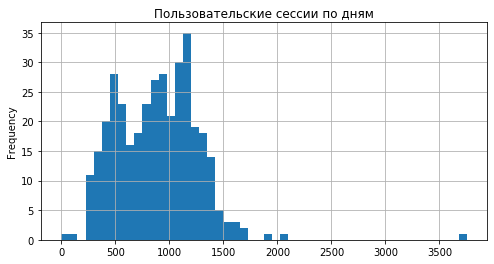

In [22]:
sessions_by_day['uid'].plot(kind='hist', bins=50, title='Пользовательские сессии по дням', figsize=(8,4), grid=True)

In [23]:
sessions_by_month = sessions.groupby('session_month').agg({'uid': 'count'})
sessions_by_month.describe()

,uid
count,12.000000
mean,26967.250000
std,9356.105397
min,12912.000000
25%,20117.250000
50%,28026.500000
75%,33685.250000
max,39795.000000


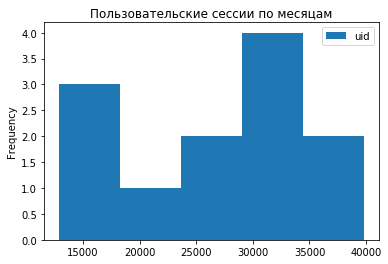

In [24]:
sessions_by_month.plot(kind='hist', bins=5, title='Пользовательские сессии по месяцам')

В день в среднем 900 сессий, в отдельные дни есть выбросы, но таких дней мало. Кол-во сессий в день распределено нормально.
В месяц в среднем 30 000 сессий.

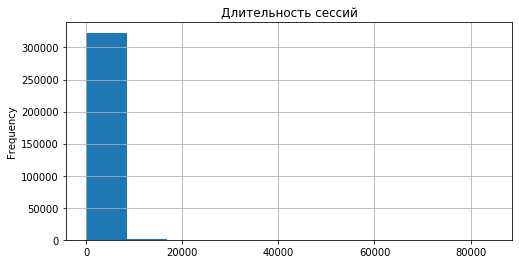

In [25]:
sessions['duration'].plot(kind='hist', bins=10, title='Длительность сессий', figsize=(8,4), grid=True)

В данных по длительности сессий есть выбросы, которые искажают общую картину. Изучим выбросы и исключим их.

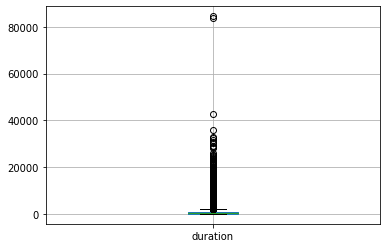

In [26]:
sessions.boxplot('duration')
plt.show()

In [27]:
left_val = sessions['duration'].describe()[4] - 1.5 * (sessions['duration'].describe()[6] - sessions['duration'].describe()[4])
right_val = sessions['duration'].describe()[6] + 1.5 * (sessions['duration'].describe()[6] - sessions['duration'].describe()[4])

print('Границы допустимых значений: ', left_val, right_val)

Границы допустимых значений:  -1050.0 2070.0


In [28]:
# удалим выбросы из данных
sessions = sessions.query('(duration > @left_val) & (duration < @right_val)')
sessions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301570 entries, 0 to 359401
Data columns (total 14 columns):
device                  301570 non-null object
end_ts                  301570 non-null datetime64[ns]
source_id               301570 non-null int64
start_ts                301570 non-null datetime64[ns]
uid                     301570 non-null uint64
session_day             301570 non-null object
session_week            301570 non-null datetime64[ns]
session_month           301570 non-null datetime64[ns]
first_session_time      301570 non-null datetime64[ns]
first_session_day       301570 non-null object
first_session_month     301570 non-null datetime64[ns]
first_session_device    301570 non-null object
first_session_source    301570 non-null int64
duration                301570 non-null int64
dtypes: datetime64[ns](6), int64(3), object(4), uint64(1)
memory usage: 34.5+ MB


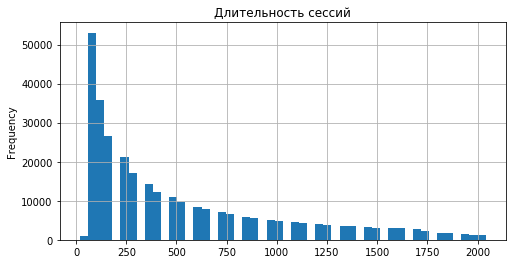

In [29]:
sessions['duration'].plot(kind='hist', bins=50, title='Длительность сессий', figsize=(8,4), grid=True)

In [30]:
sessions['duration'].describe()

count    301570.000000
mean        511.707637
std         495.745578
min          19.000000
25%         120.000000
50%         300.000000
75%         780.000000
max        2040.000000
Name: duration, dtype: float64

<font color="brown">
Кроме средней длительности сессий посмотрим какая длительность сессий встречается чаще всего
</font>

In [31]:
print('Наиболее частая длительность сессии в выборке:\n', sessions['duration'].mode())

Наиболее частая длительность сессии в выборке:
 0    60
dtype: int64


Отдельно посмотрим метрики сессий в разрезе типов платформ

In [32]:
sessions_by_device = (sessions.groupby(['device', 'session_day'])
                                .agg({'start_ts': 'count', 
                                      'uid': 'nunique', 
                                      'duration': 'mean'})
                                .reset_index())

sessions_by_device.columns = ['device', 'session_day', 'session_count', 'users', 'duration']

sessions_by_device.head()

,device,session_day,session_count,users,duration
0,desktop,2017-06-01,412,386,530.189320
1,desktop,2017-06-02,441,411,531.371882
2,desktop,2017-06-03,275,261,529.596364
3,desktop,2017-06-04,292,274,525.746575
4,desktop,2017-06-05,577,535,520.511265


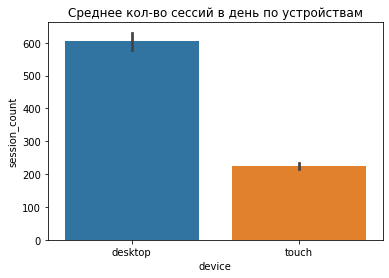

In [33]:
# Кол-во сессий в день по устройствам
sns.barplot(x='device', y='session_count', data=sessions_by_device);
plt.title('Среднее кол-во сессий в день по устройствам')
plt.show()

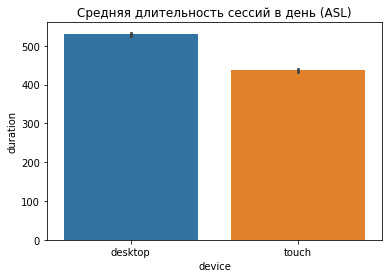

In [34]:
sns.barplot(x='device', y='duration', data=sessions_by_device);
plt.title('Средняя длительность сессий в день (ASL)')
plt.show()

Из данных по длительности сессий были удалены выбросы. Распределение длительности сессий теперь похоже на правду - с увеличением длительности кол-во сессий уменьшается.  

- <font color="brown">Наиболее часто в выборке встречаются сессии длительностью 60 сек. Можно сказать, что одна сессия длится 60 секунд</font>

- При этом средняя длительность сессии - 500 сек.
- При этом с desktop устройств приходит в 3 раза больше пользователей. И длительность сессий с desktop.

#### 2.3 Как часто люди возвращаются?
Посчитаем Retention rate для месячных когорт

In [35]:
# функция расчета когорт для Retention Rate
def draw_retention_cohort(ds):
    input = ds.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
    input.columns = ['first_session_month', 'cohort_lifetime', 'users']
    
    # начальное кол-во пользователей в когорте
    initial_users_count = input[input['cohort_lifetime'] == 0][['first_session_month','users']]
    initial_users_count.columns = ['first_session_month', 'cohort_users']
    
    input = input.merge(initial_users_count,on='first_session_month')
    input['retention'] = input['users']/input['cohort_users']
    
    output = input.pivot_table(index='first_session_month'
                                      ,columns='cohort_lifetime'
                                      ,values='retention'
                                      ,aggfunc='sum')
    
    return output

In [36]:
# Процедура для построения тепловой карты
# Параметры: 
# ds - dataset
# frame_size - список из двух значений для параметра figsize
# v_format - формат значения
# title - заголовок
# v_min - мин. значение шкалы
# v_max - макс. значение шкалы
def draw_heatmap(ds, frame_size, v_format, title, v_min, v_max):
    sns.set(style='white')
    plt.figure(figsize=frame_size)
    plt.title(title)
    
    sns.heatmap(ds, 
            annot=True, 
            fmt=v_format, 
            linewidths=.5, 
            linecolor='gray', 
            vmin=v_min, 
            vmax=v_max,
            square=True,
            yticklabels=False);
    plt.show() 

In [37]:
# Для расчета Retention rate используем сессии без выбросов по длительности сессии. 
# Это сессии настоящих пользователей, Retention rate должен получиться корректным

sessions['cohort_lifetime'] = sessions['session_month'] - sessions['first_session_month']
sessions['cohort_lifetime'] = sessions['cohort_lifetime'] / np.timedelta64(1,'M')
sessions['cohort_lifetime'] = sessions['cohort_lifetime'].astype('int')

Retention rate для всех пользователей:


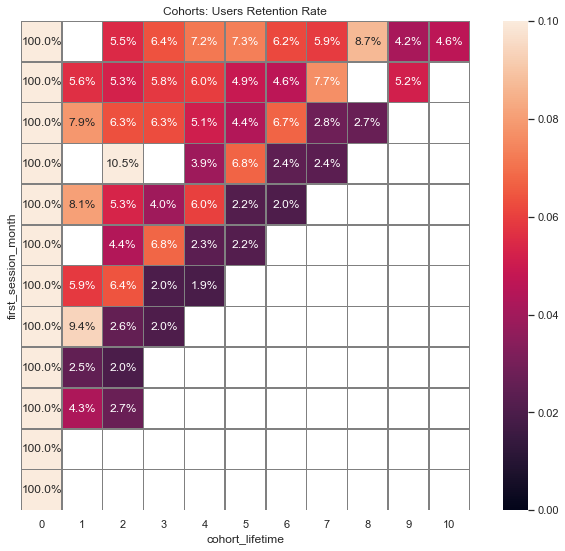

In [38]:
frame_size = (12, 9)
v_format ='.1%'
v_min = 0
v_max = .1

print('Retention rate для всех пользователей:')
rr_cohort = draw_retention_cohort(sessions)
draw_heatmap(rr_cohort, 
             frame_size, 
             v_format, 
             'Cohorts: Users Retention Rate', 
             v_min, 
             v_max)

<font color="brown">
Посчитаем также RR в разрезе устройств
</font>

Retention rate для desktop пользователей:


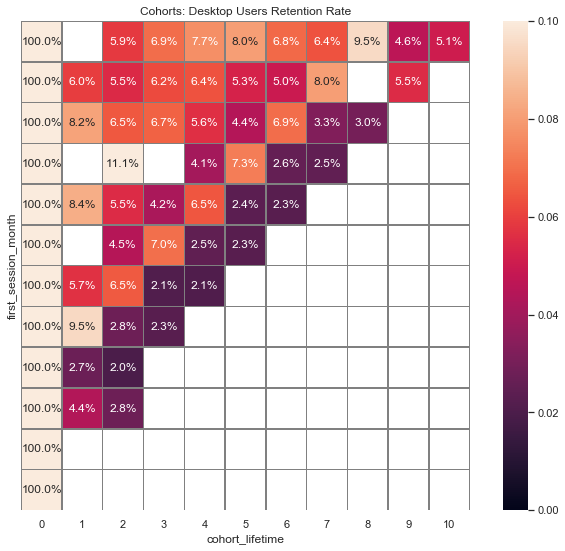

In [39]:
print('Retention rate для desktop пользователей:')
rr_cohort = draw_retention_cohort(sessions.query('first_session_device == "desktop"'))
draw_heatmap(rr_cohort, 
             frame_size, 
             v_format, 
             'Cohorts: Desktop Users Retention Rate', 
             v_min, 
             v_max)

Retention rate для touch пользователей:


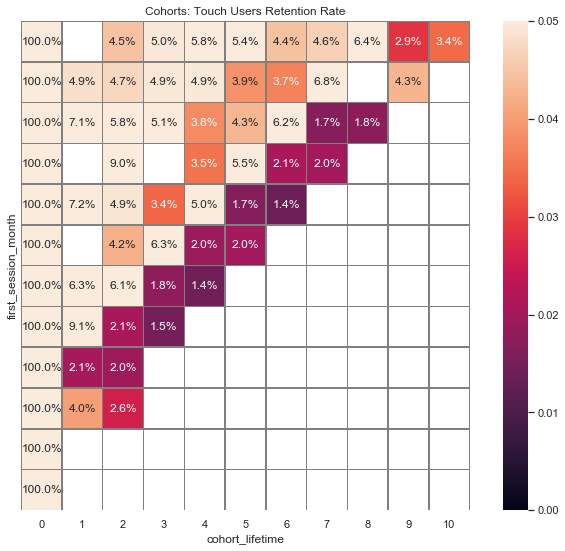

In [40]:
print('Retention rate для touch пользователей:')
rr_cohort = draw_retention_cohort(sessions.query('first_session_device != "desktop"'))

v_max = 0.05
draw_heatmap(rr_cohort, 
             frame_size, 
             v_format, 
             'Cohorts: Touch Users Retention Rate', 
             v_min, 
             v_max)

<font color="brown">
Если посмотреть на общий RR для пользователей всех платформ, то из 100% пользователей в первый месяц остается не более 9.4% во второй месяц. При этом более ранние когорты сокращались медленнее более поздних когорт.  
Для desktop пользователей (первая сессия была с desktop) картина похожая. А для пользователей touch устройств когорты угасают быстрее - 3.4% к 10-му месяцу жизни против 5.1% у desktop.

Вывод о том, что с touch устройств приходит меньше пользователей можно дополнить - Retantion rate у этих пользователей немного ниже desktop пользователей.
</font>

### 3. Изучение Продаж
Задачи:
- когда люди начинают покупать?
- сколько раз покупают за период?
- какой средний чек?
- сколько денег приносят? (LTV)

#### Выручка и кол-во заказов
Построим диаграммы по месяцам, чтобы понимать изменение ситуации по продажам в динамике

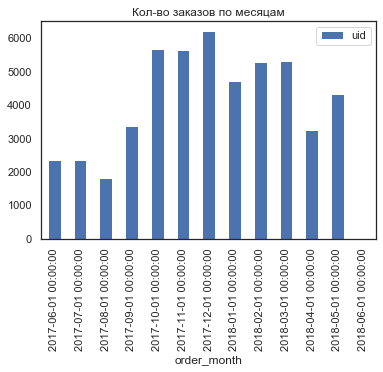

In [41]:
orders_log.groupby('order_month').agg({'uid': 'count'}).plot(kind='bar', title='Кол-во заказов по месяцам')

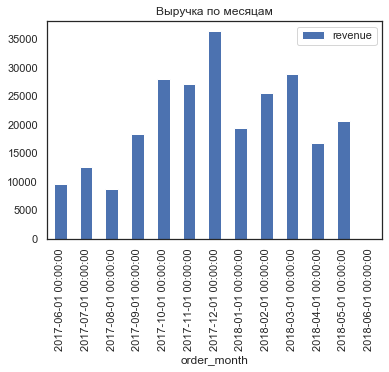

In [42]:
orders_log.groupby('order_month').agg({'revenue': 'sum'}).plot(kind='bar', title='Выручка по месяцам')

Кол-во заказов и выручка в летние месяцы минимальны, но постепенно растут осенью. Максимальное кол-во заказов и выручка в декабре.  
Т.е. можно сказать, что есть фактор сезонности в продажах. Это нужно учитывать при планировании рекламных кампаний.

#### 3.1. Когда люди начинают покупать?
Определим через сколько дней после первой сессии пользователи совершают первую покупку

In [43]:
# время первого заказа по uid
first_order_time = orders_log.groupby('uid')['buy_ts'].min()
first_order_time.name = 'first_order_time'

In [44]:
# время первой сессии по uid
first_session_time = visits_log.groupby('uid')['start_ts'].min()
first_session_time.name = 'first_session_time'

In [45]:
first_orders = pd.merge(first_order_time, first_session_time, on='uid')

In [46]:
first_orders['session_to_order_time'] = first_orders['first_order_time'] - first_orders['first_session_time']
first_orders['session_to_order_time'] = first_orders['session_to_order_time'] / np.timedelta64(1,'m')
first_orders['session_to_order_time'] = first_orders['session_to_order_time'].astype('int')

In [47]:
# проверим корректность
first_orders.query('session_to_order_time <= 0').count()

first_order_time         2451
first_session_time       2451
session_to_order_time    2451
dtype: int64

In [48]:
# удалим записи, где заказ произошел раньше или в момент первой сессии
first_orders = first_orders.query('session_to_order_time > 0')

first_orders['session_to_order_time'].describe()

count     34058.000000
mean      26113.836573
std       69888.063110
min           1.000000
25%           5.000000
50%          21.000000
75%        4439.000000
max      523144.000000
Name: session_to_order_time, dtype: float64

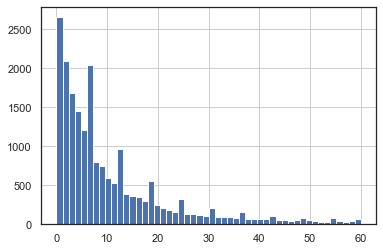

In [49]:
# Диаграмма распределения времени первой покупки относительно первой сессии
first_orders['session_to_order_time'].hist(bins=50, range=[0, 60])

50% первых покупок пользователи совершают в течении 21 минуты после начала первой сессии, т.е. скорее всего, эти покупки совершаются в процессе первой сессии пользователя.

#### 3.2 сколько раз покупают за период?
Посчитаем среднее кол-во покупок за период и среднее кол-во покупок одного пользователя за период

- <font color="brown">Расчет среднего кол-ва покупок одного пользователя за период</font>

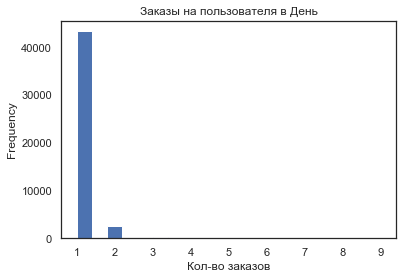

Наиболее частое кол-во заказов одного пользователя в День: 1
Среднее кол-во заказов одного пользователя в День: 1.08


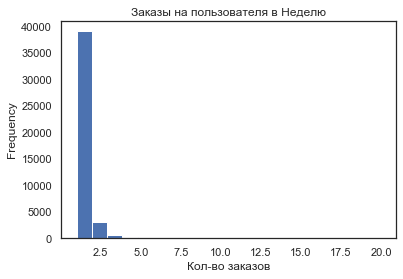

Наиболее частое кол-во заказов одного пользователя в Неделю: 1
Среднее кол-во заказов одного пользователя в Неделю: 1.16


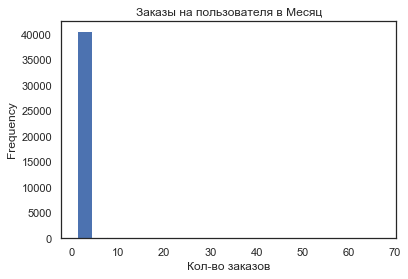

Наиболее частое кол-во заказов одного пользователя в Месяц: 1
Среднее кол-во заказов одного пользователя в Месяц: 1.23


In [50]:
for i in [['order_day', 'День'], ['order_week', 'Неделю'], ['order_month', 'Месяц']]:
    user_orders = orders_log.groupby(['uid', i[0]]).agg({'buy_ts': 'count'})
    ax = user_orders['buy_ts'].plot(kind='hist', bins=20, title='Заказы на пользователя в '+ i[1])
    ax.set_xlabel('Кол-во заказов')
    plt.show()

    print('Наиболее частое кол-во заказов одного пользователя в ' + i[1] + ':',
          user_orders['buy_ts'].mode()[0]
         )
    
    print('Среднее кол-во заказов одного пользователя в ' + i[1] + ':',
          '{:.2f}'.format(user_orders['buy_ts'].mean())
         )

- Расчет среднего кол-ва покупок за период

In [51]:
orders_per_day = orders_log.groupby('order_day').agg({'uid': 'count'})

print('Среднее кол-во покупок в день: {:.1f}'.format(orders_per_day['uid'].mean()))

Среднее кол-во покупок в день: 138.4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017026F78308>]],
      dtype=object)

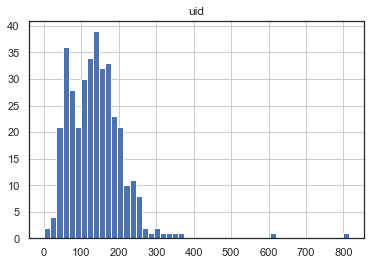

In [52]:
orders_per_day.hist(bins=50)

In [53]:
print('Среднее кол-во покупок в неделю: {:.1f}'.format(orders_log.groupby('order_week').agg({'uid': 'count'})['uid'].mean()))
print('Среднее кол-во покупок в месяц: {:.1f}'.format(orders_log.groupby('order_month').agg({'uid': 'count'})['uid'].mean()))

Среднее кол-во покупок в неделю: 950.3
Среднее кол-во покупок в месяц: 3874.2


<font color="brown">
Большенство клиентов совершает один заказ в день, неделю и месяц. Среднее кол-во заказов на клиента за период также близко к 1. Среднее кол-во заказов на пользователя в неделю - 1.16, в месяц - 1.23
</font>

В среднем все пользователи совершают:
- 138 покупок в день  
- 950 покупок в неделю 
- 3870 покупки в месяц

#### 3.3 какой средний чек?
Посчитаем среднюю выручку сервиса по заказам

In [54]:
orders_log['revenue'].describe()

count    50364.000000
mean         5.004710
std         21.828823
min          0.010000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

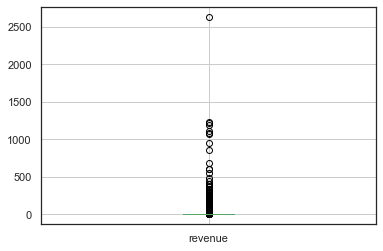

In [55]:
# можно предположить наличие выбросов в данных
orders_log.boxplot('revenue')

In [56]:
right_val = (orders_log['revenue'].describe()[6] 
            + 1.5 * (sessions['duration'].describe()[6] - sessions['duration'].describe()[4]))

In [57]:
orders_log = orders_log.query('revenue <= @right_val')
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50357 entries, 0 to 50363
Data columns (total 8 columns):
buy_ts                  50357 non-null datetime64[ns]
revenue                 50357 non-null float64
uid                     50357 non-null uint64
order_day               50357 non-null object
order_week              50357 non-null datetime64[ns]
order_month             50357 non-null datetime64[ns]
first_order_month       50357 non-null datetime64[ns]
first_session_device    50357 non-null object
dtypes: datetime64[ns](4), float64(1), object(2), uint64(1)
memory usage: 3.5+ MB


In [58]:
print('Средний чек по всем пользователям:')
orders_log['revenue'].describe()

Средний чек по всем пользователям:


count    50357.000000
mean         4.815775
std         13.486167
min          0.010000
25%          1.220000
50%          2.500000
75%          4.890000
max        948.440000
Name: revenue, dtype: float64

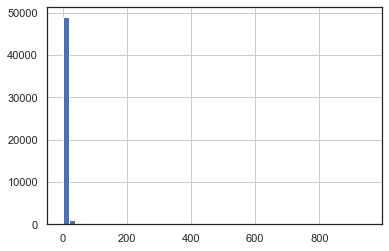

In [59]:
orders_log['revenue'].hist(bins=50)

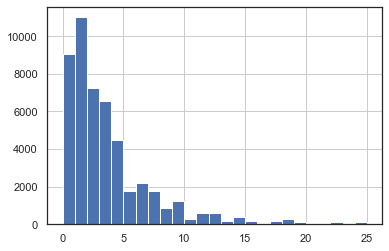

In [60]:
orders_log['revenue'].hist(bins=25, range=[0, 25])

In [61]:
print('Средний чек по desktop пользователям:')
orders_log.query('first_session_device == "desktop"')['revenue'].describe()

Средний чек по desktop пользователям:


count    40871.000000
mean         4.937010
std         14.365251
min          0.010000
25%          1.280000
50%          2.690000
75%          4.890000
max        948.440000
Name: revenue, dtype: float64

In [62]:
print('Средний чек по touch пользователям:')
orders_log.query('first_session_device != "desktop"')['revenue'].describe()

Средний чек по touch пользователям:


count    9486.000000
mean        4.293425
std         8.721325
min         0.030000
25%         1.220000
50%         2.440000
75%         4.670000
max       273.780000
Name: revenue, dtype: float64

Средний чек = 5 руб, но если предположить, что Афиша зарабатывает только на продаже билетов и средняя стоимость одного билета 300 руб, то маржинальность сервиса 1.5%. Как то очень мало для сервиса - агрегатора. Должно быть раз в 10 больше.

Для пользователей с touch устройствами средний чек немного ниже 4.2 руб, для desktop немного выше 5.1 руб.

#### 3.4 сколько денег приносят? (LTV)
Посчитаем LTV по когортам для всех пользователей и в разрезе устройств.

In [63]:
def draw_ltv_cohort(ds):
    input = ds.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()
    
    # кол-во покупателей в когортах
    cohorts_size = ds.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohorts_size.columns = ['first_order_month', 'n_buyers']

    input = pd.merge(input, cohorts_size, on='first_order_month')

    # возраст когорт
    input['age'] = (input['order_month'] - input['first_order_month']) / np.timedelta64(1, 'M')
    input['age'] = input['age'].round().astype('int')

    # LTV
    input['ltv'] = input['revenue'] / input['n_buyers']

    output = input.pivot_table(index='first_order_month', 
                               columns='age', 
                               values='ltv', 
                               aggfunc='mean')

    # пересчитаем LTV накопительным итогом
    output = output.cumsum(axis=1).round(2)
    return output

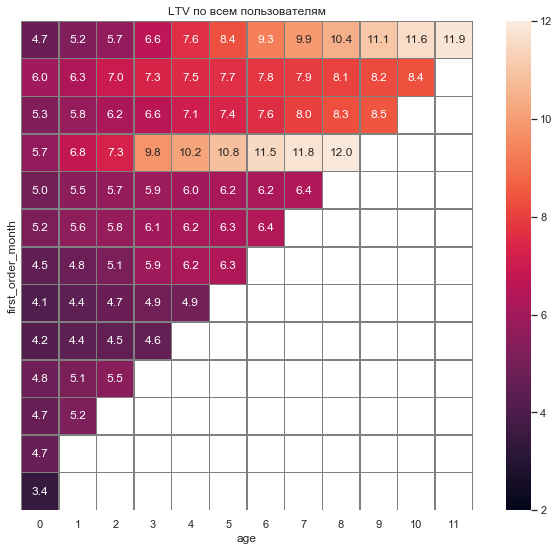

In [64]:
frame_size = (12, 9)
ltv_pivot = draw_ltv_cohort(orders_log)

draw_heatmap(ltv_pivot, 
             frame_size, 
             '.1f', 
             'LTV по всем пользователям', 
             2, 
             12)

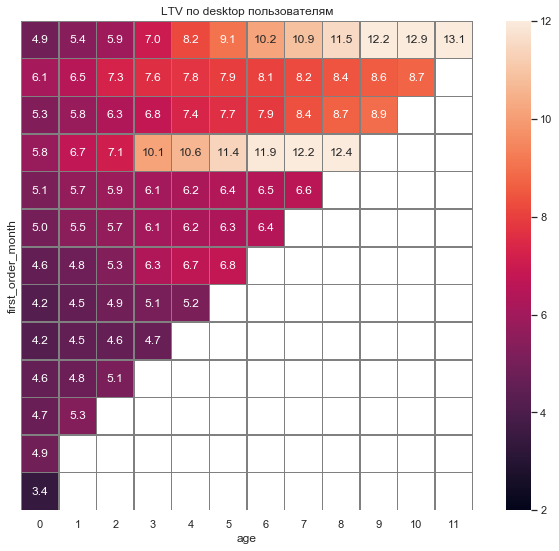

In [65]:
ltv_desktop = draw_ltv_cohort(orders_log.query('first_session_device == "desktop"'))

draw_heatmap(ltv_desktop, 
             frame_size, 
             '.1f', 
             'LTV по desktop пользователям', 
             2, 
             12)

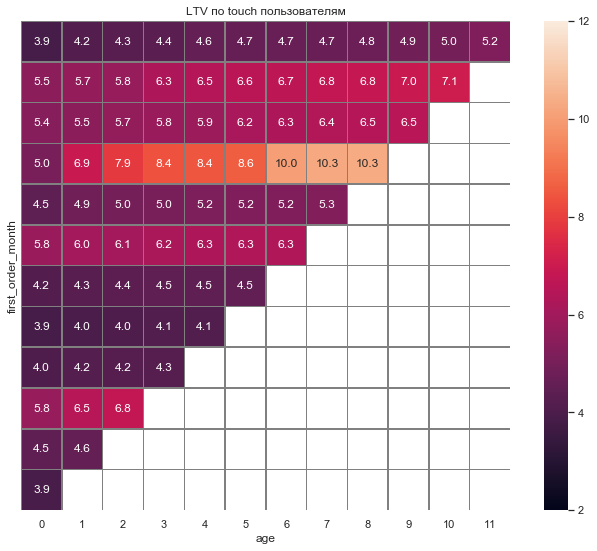

In [66]:
ltv_touch = draw_ltv_cohort(orders_log.query('first_session_device != "desktop"'))

draw_heatmap(ltv_touch, 
             frame_size, 
             '.1f', 
             'LTV по touch пользователям', 
             2, 
             12)

- __LTV по всем пользователям__ - для наиболее старой когорты '2017-06-01' LTV = 11.9 руб.
Однозначной динамики в когортах не видно - какие-то когорты более прибыльны, какие-то менее прибыльны.

- __LTV по desktop пользователям__ немного выше чем по всем пользователям. Для когорты '2017-06-01' LTV = 13.1 руб

- __LTV по touch пользователям__ существенно ниже. Для когорты '2017-06-01' LTV = 5.2 руб

### 3. Изучение Маркетинга
Задачи:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

#### 3.1 Сколько денег потратили? Всего / на каждый источник / по времени
Расчитаем CAC по каналам привлечения трафика и по месяцам

In [67]:
costs_total = costs['costs'].sum()
print('Общие расходы на маркетинг: ', costs_total)

Общие расходы на маркетинг:  329131.62


In [68]:
# расходы по месяцам
costs_by_month = costs.groupby('cost_month').agg({'costs': 'sum'})
print(costs_by_month)

               costs
cost_month          
2017-06-01  18015.00
2017-07-01  18240.59
2017-08-01  14790.54
2017-09-01  24368.91
2017-10-01  36322.88
2017-11-01  37907.88
2017-12-01  38315.35
2018-01-01  33518.52
2018-02-01  32723.03
2018-03-01  30415.27
2018-04-01  22289.38
2018-05-01  22224.27


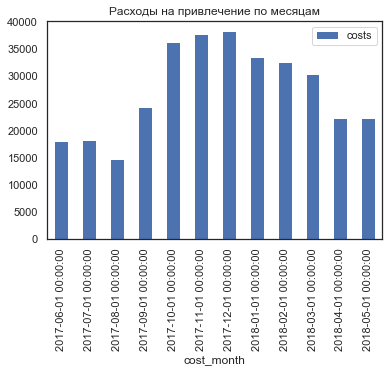

In [69]:
costs_by_month.plot(kind='bar', title='Расходы на привлечение по месяцам')

In [70]:
# расходы по каналам
costs_by_source = costs.groupby('source_id').agg({'costs': 'sum'})
print(costs_by_source)

               costs
source_id           
1           20833.27
2           42806.04
3          141321.63
4           61073.60
5           51757.10
9            5517.49
10           5822.49


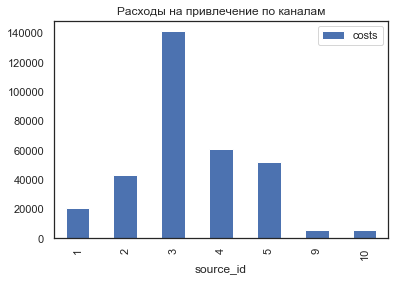

In [71]:
costs_by_source.plot(kind='bar', title='Расходы на привлечение по каналам')

Рассчитаны суммарные расходы по месяцам и каналам привлечения пользователей. Максимальные расходы на маркетинг были в ноябре - декабре 2017 г. Канал 3 - лидер по общим расходам.  
Для каналов 6, 7, 8 нет данных по расходам.

#### 3.2 Сколько стоило привлечение одного покупателя из каждого источника?
Посчитаем кол-во привлеченных пользователей и покупателей для каждого канала. Модель атрибуции - Первый переход (First click).
Также посчитаем конверсию в заказ, customer acquisition cost, cost per user.

In [72]:
# уникальные пользователи по каналам
users_by_source = visits_log.groupby('first_session_source').agg({'uid': 'nunique'}).reset_index()
users_by_source.columns = ['source_id', 'n_users']

print(users_by_source)

   source_id  n_users
0          1     9469
1          2    17616
2          3    66116
3          4    72346
4          5    49237
5          6        2
6          7       32
7          9     6448
8         10     6903


In [73]:
# уникальные покупатели по каналам
# список уникальных покупателей
buyers = orders_log['uid'].unique()

customers_by_source = visits_log.query('uid in @buyers')
customers_by_source = customers_by_source.groupby('first_session_source').agg({'uid': 'nunique'}).reset_index()
customers_by_source.columns = ['source_id', 'n_customers']
print(customers_by_source)

   source_id  n_customers
0          1         2896
1          2         3503
2          3        10467
3          4        10296
4          5         6931
5          7            1
6          9         1088
7         10         1327


In [74]:
# тут используется inner join - в выборку попадут только каналы, по которым были расходы
sources = pd.merge(costs_by_source, users_by_source, on='source_id')
sources = pd.merge(sources, customers_by_source, on='source_id')

print(sources)

   source_id      costs  n_users  n_customers
0          1   20833.27     9469         2896
1          2   42806.04    17616         3503
2          3  141321.63    66116        10467
3          4   61073.60    72346        10296
4          5   51757.10    49237         6931
5          9    5517.49     6448         1088
6         10    5822.49     6903         1327


In [75]:
# посчитаем конверсию по каналам
sources['conversion'] = sources['n_customers']/sources['n_users']
print(sources)

   source_id      costs  n_users  n_customers  conversion
0          1   20833.27     9469         2896    0.305840
1          2   42806.04    17616         3503    0.198853
2          3  141321.63    66116        10467    0.158313
3          4   61073.60    72346        10296    0.142316
4          5   51757.10    49237         6931    0.140768
5          9    5517.49     6448         1088    0.168734
6         10    5822.49     6903         1327    0.192235


In [76]:
# стоимости привлечения
# CAC - стоимость привлечение платящего пользователя
# CPUser - стоимость привлечения пользователя
sources['cac'] = sources['costs'] / sources['n_customers']
sources['cpuser'] = sources['costs'] / sources['n_users']
print(sources)

   source_id      costs  n_users  n_customers  conversion        cac    cpuser
0          1   20833.27     9469         2896    0.305840   7.193809  2.200155
1          2   42806.04    17616         3503    0.198853  12.219823  2.429952
2          3  141321.63    66116        10467    0.158313  13.501637  2.137480
3          4   61073.60    72346        10296    0.142316   5.931779  0.844188
4          5   51757.10    49237         6931    0.140768   7.467479  1.051183
5          9    5517.49     6448         1088    0.168734   5.071222  0.855690
6         10    5822.49     6903         1327    0.192235   4.387709  0.843472


In [77]:
sources.set_index('source_id', inplace=True)

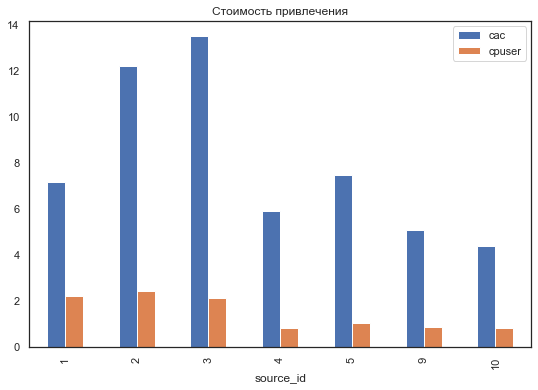

In [78]:
sources[['cac', 'cpuser']].plot(kind='bar', title='Стоимость привлечения', figsize=(9, 6))

Расчитаны стоимости привлечения пользователей и покупателей по источникам. Самые дорогие каналы привлечения - это 3, 2, 5. 

### 3.3 На сколько окупились расходы? (ROI)

- Посчитаем ROMI для когорт - показатель не будет учитывать каналы привлечения пользователей, но покажет на сколько в целом сервис окупается с учетом повторных заказов.
- И затем посчитаем ROMI для когорт по отдельным каналам привлечения

- Расчет ROMI для когорт

In [79]:
# расходы по месяцам
monthly_costs = costs.groupby('cost_month').agg({'costs': 'sum'})

print(monthly_costs.head())

               costs
cost_month          
2017-06-01  18015.00
2017-07-01  18240.59
2017-08-01  14790.54
2017-09-01  24368.91
2017-10-01  36322.88


In [80]:
# Функция расчета romi по когортам
# Параметры:
# ds - заказы
# ds_costs - расходы по месяцам
def draw_romi_cohort(ds, ds_costs):
    input = ds.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

    # кол-во покупателей в когортах
    cohorts_size = ds.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohorts_size.columns = ['first_order_month', 'n_buyers']
    input = pd.merge(input, cohorts_size, on='first_order_month')

    # возраст когорт
    input['age'] = (input['order_month'] - input['first_order_month']) / np.timedelta64(1, 'M')
    input['age'] = input['age'].round().astype('int')

    input['ltv'] = input['revenue'] / input['n_buyers']
    
    input = pd.merge(input, ds_costs, left_on='first_order_month', right_on='cost_month')
    input['cac'] = input['costs'] / input['n_buyers']

    input['romi'] = input['ltv'] / input['cac']
    output = input.pivot_table(index='first_order_month', 
                               columns='age', 
                               values='romi', 
                               aggfunc='mean')

    output = output.cumsum(axis=1).round(2)
    return output

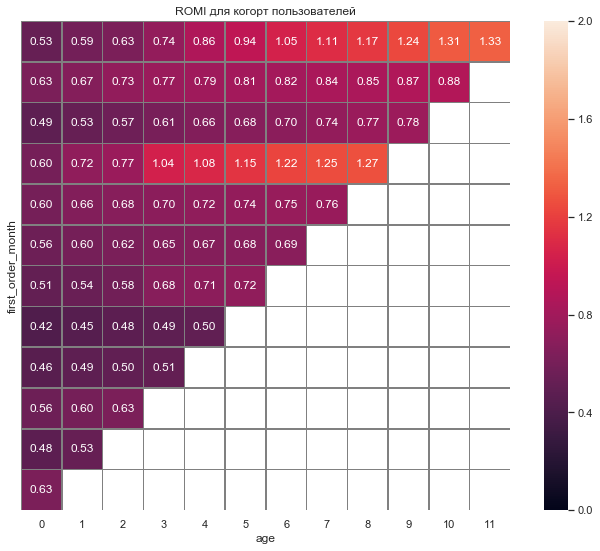

In [81]:
frame_size=(12, 9)
draw_heatmap(draw_romi_cohort(orders_log, monthly_costs), 
             frame_size, 
             '.2f', 
             'ROMI для когорт пользователей', 
             0, 
             2)

Только 2 когорты в итоге окупились:  
2017-06-01 - на 6-м месяце
2017-09-01 - на 3-м

У остальных когорт доходность ниже окупаемости

- Расчет ROMI для когорт пользователей сгруппированных по каналу привлечения пользователя в первую сессию

In [82]:
# нам нужен датасет, в котором будут uid + месяц первога заказа + месяц заказа + revenue + расходы за месяц
# данные по заказам
t_orders = orders_log[['uid', 'revenue', 'order_month', 'first_order_month']]
t_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50357 entries, 0 to 50363
Data columns (total 4 columns):
uid                  50357 non-null uint64
revenue              50357 non-null float64
order_month          50357 non-null datetime64[ns]
first_order_month    50357 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), uint64(1)
memory usage: 1.9 MB


In [83]:
# первые сессии пользователей
t_visits = visits_log[['uid', 'first_session_source']]
t_visits = t_visits.drop_duplicates()

t_visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228169 entries, 0 to 359401
Data columns (total 2 columns):
uid                     228169 non-null uint64
first_session_source    228169 non-null int64
dtypes: int64(1), uint64(1)
memory usage: 5.2 MB


In [84]:
# расходы по каналам и месяцам
t_costs = costs.groupby(['source_id', 'cost_month']).agg({'costs': 'sum'}).reset_index()
t_costs.columns = ['first_session_source', 'first_order_month', 'costs']

In [85]:
t_romi = pd.merge(t_orders, t_visits, on='uid')
t_romi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50357 entries, 0 to 50356
Data columns (total 5 columns):
uid                     50357 non-null uint64
revenue                 50357 non-null float64
order_month             50357 non-null datetime64[ns]
first_order_month       50357 non-null datetime64[ns]
first_session_source    50357 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(1), uint64(1)
memory usage: 2.3 MB


In [86]:
t_cohorts = t_romi.groupby(['first_session_source', 'first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

# добавим возраст когорт
t_cohorts['age'] = (t_cohorts['order_month'] - t_cohorts['first_order_month']) / np.timedelta64(1, 'M')
t_cohorts['age'] = t_cohorts['age'].round().astype('int')

# добавим расходы
t_cohorts = pd.merge(t_cohorts, t_costs, on=['first_session_source', 'first_order_month'])
t_cohorts['roi'] =  t_cohorts['revenue']/t_cohorts['costs']

In [87]:
def draw_cohorts(source_id):
    input = t_cohorts.query('first_session_source == @source_id')

    output = input.pivot_table(index='first_order_month', 
                                   columns='age', 
                                   values='roi', 
                                   aggfunc='sum')

    # пересчитаем LTV накопительным итогом
    output = output.cumsum(axis=1).round(2)
    
    return output

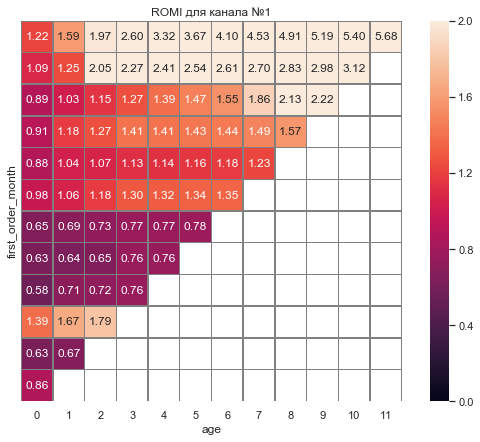

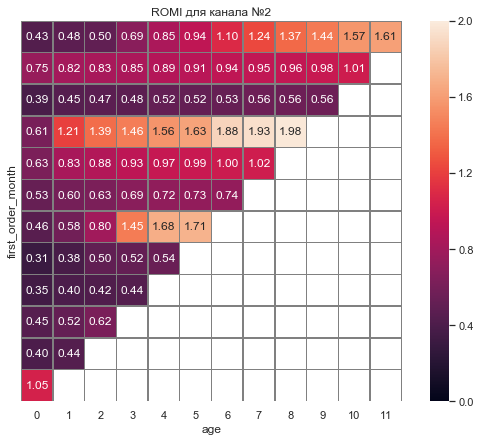

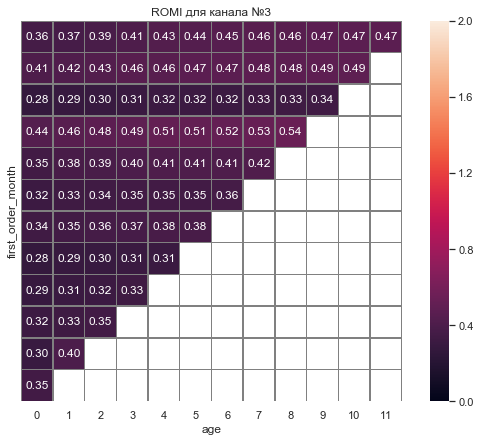

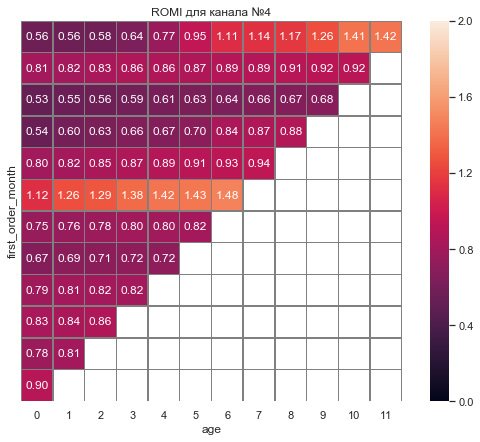

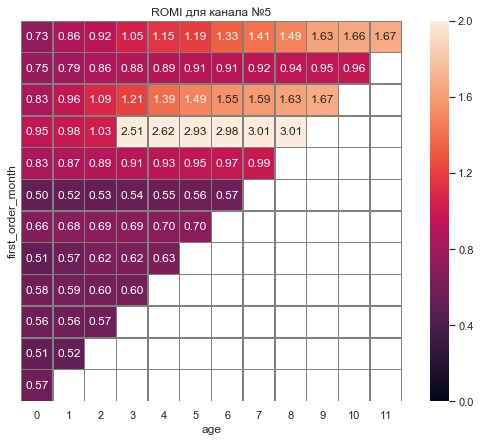

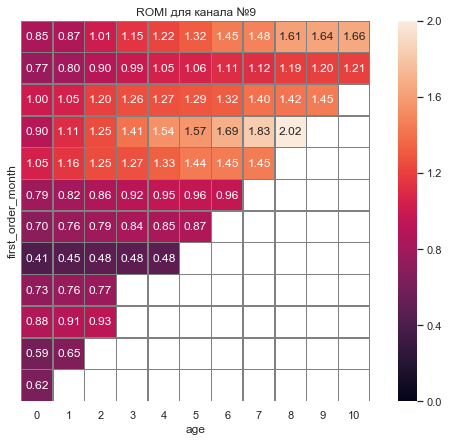

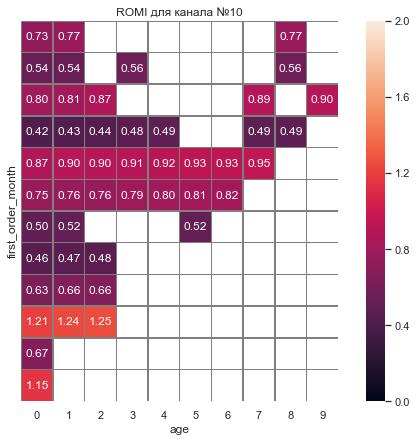

In [88]:
for i in [1, 2, 3, 4, 5, 9, 10]:
    
    frame_size=(10, 7)
    draw_heatmap(draw_cohorts(i), 
             frame_size, 
             '.2f', 
             'ROMI для канала №' + str(i), 
             0, 
             2)

- Максимальный ROMI = 5.68 (сравниваем по первой когорте) у источника 1
- Окупаются источники: 1, 2, 4, 5, 9

## Вывод

### Продукт
#### Аудитория сервиса
- Показатели аудитории сервиса:  
    DAU: 907  
    WAU: 5716  
    MAU: 23228  
- С desktop устройств пользователей приходит в 2 раза больше чем с других устройств
- Рекламные кампании с source_id - 4, 3, 5 приводят наибольшее кол-во пользователей
- Рекламные каналы 6, 7, 8 приводят минимальное кол-во пользователей.

#### Сессии пользователей
Из данных по длительности сессий были удалены выбросы.
- Средняя длительность сессии 500 сек.
- При этом с desktop устройств приходит в 3 раза больше пользователей. И длительность сессий с desktop выше.

#### Retention rate
Если посмотреть на общий RR для пользователей всех платформ, то из 100% пользователей в первый месяц остается не более 9.4% во второй месяц. При этом более ранние когорты сокращались медленнее более поздних когорт.    
Для desktop пользователей (первая сессия была с desktop) картина похожая. А для пользователей touch устройств когорты угасают быстрее - 3.4% к 10-му месяцу жизни против 5.1% у desktop.  
Вывод о том, что с touch устройств приходит меньше пользователей можно дополнить - Retantion rate у этих пользователей немного ниже desktop пользователей.

### Продажи
#### Выручка и кол-во заказов
Кол-во заказов и выручка в летние месяцы минимальны, но постепенно растут осенью. Максимальное кол-во заказов и выручка в декабре.  
Т.е. можно сказать, что есть фактор сезонности в продажах. Это нужно учитывать при планировании рекламных кампаний.

#### Заказы и средний чек
50% первых покупок пользователи совершают в течении 21 минуты после начала первой сессии, т.е. скорее всего, эти покупки совершаются в процессе первой сессии пользователя.

Большенство клиентов совершает один заказ в день, неделю и месяц. Среднее кол-во заказов на клиента за период также близко к 1. Среднее кол-во заказов на пользователя в неделю - 1.16, в месяц - 1.23

В среднем все пользователи совершают:
- 138 покупок в день  
- 950 покупок в неделю 
- 3870 покупки в месяц

Средний чек = 5 руб, но если предположить, что Афиша зарабатывает только на продаже билетов и средняя стоимость одного билета 300 руб, то маржинальность сервиса 1.5%. Как то очень мало для сервиса - агрегатора. Должно быть раз в 10 больше.

Для пользователей с touch устройствами средний чек немного ниже 4.2 руб, для desktop немного выше 5.1 руб.

#### LTV
- LTV по всем пользователям - для наиболее старой когорты '2017-06-01' LTV = 11.9 руб.
Однозначной динамики в когортах не видно - какие-то когорты более прибыльны, какие-то менее прибыльны.

- LTV по desktop пользователям немного выше чем по всем пользователям. Для когорты '2017-06-01' LTV = 13.1 руб

- LTV по touch пользователям существенно ниже. Для когорты '2017-06-01' LTV = 5.2 руб

### Маркетинг
#### Сколько денег потратили?
Рассчитаны суммарные расходы по месяцам и каналам привлечения пользователей. Максимальные расходы на маркетинг были в ноябре - декабре 2017 г. Канал 3 - лидер по общим расходам. Для каналов 6, 7, 8 нет данных по расходам.

#### Сколько стоило привлечение одного покупателя из каждого источника?
Рассчитано кол-во привлеченных пользователей и покупателей для каждого канала. Модель атрибуции - Первый переход (First click).
Рассчитана конверсия в заказ, customer acquisition cost, cost per user.

In [89]:
print(sources)

               costs  n_users  n_customers  conversion        cac    cpuser
source_id                                                                  
1           20833.27     9469         2896    0.305840   7.193809  2.200155
2           42806.04    17616         3503    0.198853  12.219823  2.429952
3          141321.63    66116        10467    0.158313  13.501637  2.137480
4           61073.60    72346        10296    0.142316   5.931779  0.844188
5           51757.10    49237         6931    0.140768   7.467479  1.051183
9            5517.49     6448         1088    0.168734   5.071222  0.855690
10           5822.49     6903         1327    0.192235   4.387709  0.843472


Самая высокая конверсия для источников: 1, 2.  
Самые дорогие каналы привлечения - это 3, 2, 5.

#### На сколько окупились расходы? (ROI)
- Посчитан ROMI для когорт, затраты на привлечение отнесены на месяц основания когорты - показатель не учитывает каналы привлечения пользователей, но показывает на сколько в целом сервис окупается с учетом повторных заказов.
  
    Только 2 когорты в итоге окупились:  
    2017-06-01 - на 6-м месяце  
    2017-09-01 - на 3-м

    У остальных когорт доходность ниже окупаемости.


- Посчитан ROMI для когорт с учетом каналов привлечения - для пользователей определен источник первой сессии и затем сформированы месячные когорты.
  
    Максимальный ROMI = 5.68 (сравниваем по первой когорте) у источника 1.  
    Окупаются источники: 1, 2, 4, 5, 9

#### Рекомендации
- Наилучшая доходность у источников привлечения 1, 4 и 9. Эти каналы также имеют невысокую стоимость привлечения (CAC). У канала 1 максимальная конверсия в первый заказ.
Т.е. для источников 1, 4 и 9 следует увеличивать расходы на привлечение пользователей.
- Каналы 3 и 10 не окупаются. Канал 3 - лидер по расходам и стоимости привлечения (CAC). При этом конверсия в заказ из этого канала невысокая. Имеет смысл перераспределить расходы на привлечения от каналов 3 и 10 на каналы 1, 4 и 9.

- <font color="brown"> Поведение пользователей с desktop и touch устройств сильно различается.   
С desktop приходит в 3 раза больше пользователей, длительность их сессий выше, Retention Rate также выше. Средний чек по платформам практически не различается, но LTV для desktop в 2 раза выше.  
Можно предположить, что сервис не очень удобно использовать с мобильных устройств - люди редко возвращаются, из-за этого низкий RR и LTV.  
Учитывая, что доля мобильного трафика стабильно растет и кол-во посетителей сайтов с мобильных устройств будет только увеличиваться необходимо повышать удобство пользования сервисом с мобильных устройств, повышать кол-во и длительность сессий, работать над увеличением LTV.  
</font>